# Salary Predictions Based on Job Descriptions

The goal of this project is to develop a model that ingests features like company information, candidate qualification, degree etc to predict the salary of a particular role defined uniquely by a jobId. 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Scikit Learn pre-processing libraries needed
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# sklearn ML libraries 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb

# New regression base lib which helps with building visuals of the results
from yellowbrick.regressor import ResidualsPlot


# author info 
__author__ = "Aadithya Ramasubramaniam"
__email__ = "aadithya.viswanath@gmail.com"

### ---- Loading the data ----

In [2]:
# load the data into a Pandas dataframe
Test_Features = pd.read_csv('/Users/raviswanath/Dropbox/data/test_features.csv')
Train_Features = pd.read_csv('/Users/raviswanath/Dropbox/data/train_features.csv')
Train_Salaries = pd.read_csv('/Users/raviswanath/Dropbox/data/train_salaries.csv')

### ---- Data cleaning and exploration ----

### Check and remove outliers

In [9]:
numeric_cols = Training_data.select_dtypes(exclude='object')
categoriacl_cols = Training_data.select_dtypes(exclude=['int64', 'float64'])

In [10]:
[cols for cols in numeric_cols.columns if (numeric_cols[cols] <= 0).any()]

['yearsExperience', 'milesFromMetropolis', 'salary']

In [11]:
Training_data[Training_data.salary <=0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [12]:
Train_Features[Train_Features.yearsExperience < 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


In [13]:
Train_Features[Train_Features.milesFromMetropolis < 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


In [14]:
# Removing rows with salary = 0
Training_data = Training_data[Training_data.salary > 0]

In [15]:
Training_data.jobType.value_counts()

SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64

In [16]:
Training_data.groupby(['jobType'])['yearsExperience', 'salary'].median()

,yearsExperience,salary
jobType,,
CEO,12,142
CFO,12,132
CTO,12,132
JANITOR,12,68
JUNIOR,12,92
MANAGER,12,112
SENIOR,12,102
VICE_PRESIDENT,12,122


In [17]:
# Function to remove records which have less than x% of rows in a certain salary range

def remove_extremes(Training_data, tune_param):
    '''Function to remove records which have less than x% of rows in a certain salary range'''
    
    rows_removed = 0
    Job_Types = Training_data.jobType.unique()
    
    for j in Job_Types:
        x = Training_data[Training_data.jobType==j]['salary'].count()
        for i in range(0, 100, 10):
            #identify records in the certain bin for jobType j
            y = Training_data[(Training_data.jobType == j) &
                (Training_data.salary >= np.percentile(Training_data.salary, i)) & 
                (Training_data.salary < np.percentile(Training_data.salary, (i+10)))]['salary'].count()

            if((y/x)*100 < tune_param):
                    # keep count of the number of rows removed
                    rows_removed = rows_removed + y

                    # eliminate the records
                    Training_data = Training_data.loc[~((Training_data.jobType == j)&
                                    (Training_data.salary >= np.percentile(Training_data.salary, i))&
                                    (Training_data.salary < np.percentile(Training_data.salary, (i+10)))),:]
    print(rows_removed)
    return(Training_data)

In [18]:
# Change the tuning parameter here to remove more and more rows. 
Training_data = remove_extremes(Training_data, 2.5)

9587


In [19]:
Training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990408 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  990408 non-null object
companyId              990408 non-null object
jobType                990408 non-null object
degree                 990408 non-null object
major                  990408 non-null object
industry               990408 non-null object
yearsExperience        990408 non-null int64
milesFromMetropolis    990408 non-null int64
salary                 990408 non-null int64
dtypes: int64(3), object(6)
memory usage: 75.6+ MB


In [20]:
# Removing all entries with salaries greater than 250
Training_data = Training_data[Training_data.salary < 250]

In [21]:
Training_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


### ----Establishing a baseline ----

In [42]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

In [43]:
# creating baseline values
Baseline_salary = Training_data.groupby(['industry', 'jobType'])['salary'].median().reset_index()
Baseline_data = Training_data
salary = Baseline_data['salary']
Baseline_data.drop('salary', axis=1, inplace=True)

In [44]:
# Splitting the data to training and test sets
train_predictors, test_predictors, train_salary, test_salary = train_test_split(Baseline_data, 
                                                                                salary, 
                                                                                test_size=0.3,
                                                                                random_state=42)

In [45]:
# Select categorical columns and check their cardinality
categorical_cols = [cols for cols in train_predictors.columns 
                   if train_predictors[cols].dtype == 'object']

# cardinality
for col in categorical_cols:
    print(col, ":", train_predictors[col].nunique())

jobId : 692679
companyId : 63
jobType : 8
degree : 5
major : 9
industry : 7


In [46]:
# only keep columns which have a cardinality < 10
categorical_cols = [col for col in categorical_cols 
                   if train_predictors[col].nunique() <= 10]

# numerical cols
numeric_cols = [col for col in train_predictors.columns
               if train_predictors[col].dtype in ["int64", "float64"]]

In [47]:
# Fitting a basic regression model
basic_model = LinearRegression()

In [48]:
# one hot encoding categorical features
New_data = pd.get_dummies(train_predictors[categorical_cols])

train_predictors = train_predictors.select_dtypes(exclude=['object'])
train_predictors = pd.concat([train_predictors, New_data], axis=1)

In [49]:
# Fitting a basic regression model
basic_model = LinearRegression()
cv_results = cross_val_score(basic_model, train_predictors, 
                            train_salary,
                            cv=5)

In [50]:
# r2 values for 5-fold CV
cv_results

array([0.74394952, 0.74644446, 0.74389   , 0.74442228, 0.74309522])

In [51]:
# making predictions and comparing results against baseline averages

avg_sal_test = test_predictors.merge(Baseline_salary, on=['industry', 'jobType'])
avg_sal_test = avg_sal_test['salary']

# preparing the test set for making predictions
test_predictors_encodes = pd.get_dummies(test_predictors[categorical_cols])
test_predictors = test_predictors.select_dtypes(exclude=['object'])
test_predictors = pd.concat([test_predictors, test_predictors_encodes], axis=1)

# making predictions and finding the MSE 
basic_model.fit(train_predictors, train_salary)
basic_predictions = basic_model.predict(test_predictors)
mean_squared_error(test_salary, basic_predictions)

376.2205424059204

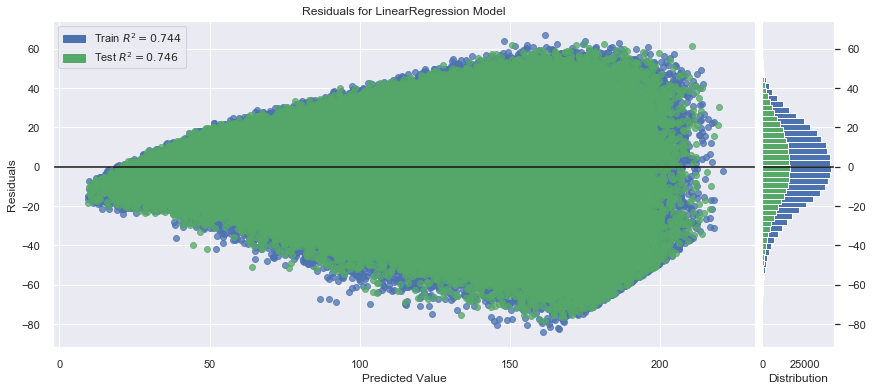

In [52]:
# regression with residual plot
v = ResidualsPlot(LinearRegression())
v.fit(train_predictors, train_salary)
v.score(test_predictors, test_salary)
v.poof()

In [53]:
# Model efficacy (compared to a basline model)
mean_squared_error(test_salary, avg_sal_test)

2170.0109680222863

In [54]:
# % Improvement offered over a simple baseline solution
(abs(mean_squared_error(test_salary, avg_sal_test) - 
    mean_squared_error(test_salary, basic_predictions))/ (mean_squared_error(test_salary, avg_sal_test)))*100

82.6627354446599

### ---- Testing different models ----

In [55]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

In [56]:
# converting the training records into numpy arrays to enhance processing speed
feature_list = list(train_predictors.columns)
train_predictors = np.array(train_predictors)
test_predictors = np.array(test_predictors)

train_salary = np.array(train_salary)
test_salary = np.array(test_salary)

In [57]:
train_predictors

array([[16, 79,  0, ...,  0,  0,  0],
       [ 4, 70,  0, ...,  0,  0,  0],
       [11, 14,  0, ...,  0,  0,  0],
       ...,
       [10, 46,  0, ...,  1,  0,  0],
       [14, 16,  1, ...,  0,  0,  0],
       [12,  2,  0, ...,  0,  0,  0]])

### Cross validation and tuning with Lasso

In [58]:
from sklearn.linear_model import LassoCV
l1_cv = LassoCV(n_jobs=-1,
               cv=5, max_iter=100, 
               random_state=42)

In [59]:
l1_cv.fit(train_predictors, train_salary)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=100, n_alphas=100, n_jobs=-1, normalize=False, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

In [60]:
l1_cv.alpha_

0.32047919763902105

In [61]:
l1_cv_predictions = l1_cv.predict(test_predictors)
mean_squared_error(test_salary, l1_cv_predictions)

395.4895721068017

### Cross validation and tuning a Random Forest model

In [62]:
# 5 fold cross validation with Random Forest
rf_model = RandomForestRegressor(n_jobs=-1)
cv_rf = cross_val_score(rf_model, train_predictors, train_salary,
                       cv=3, n_jobs=-1)
cv_rf.mean()

0.6912758789331169

In [63]:
rf_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [64]:
# Tuning the Random Forest Model

# Max features
max_features = ['auto', 'log2', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 3)]

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 15, 20]

# Create the random grid
random_grid = {
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

print(random_grid)

{'max_features': ['auto', 'log2', 'sqrt'], 'max_depth': [5, 10, 15], 'min_samples_split': [5, 10, 15, 20], 'min_samples_leaf': [5, 10, 15, 20]}


In [65]:
# change in version produces loads of warnings, keeping note of them and ignoring them for presentation
import warnings
warnings.filterwarnings('ignore')

In [66]:
# Random search to tune hyper parameters
rf_model = RandomForestRegressor(random_state=123,
                                n_jobs=-1)

rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                              cv=3)

rf_random.fit(train_predictors, train_salary)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=123, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': ['auto', 'log2', 'sqrt'], 'max_depth': [5, 10, 15], 'min_samples_split': [5, 10, 15, 20], 'min_samples_leaf': [5, 10, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [67]:
rf_random.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 15,
 'max_features': 'auto',
 'max_depth': 15}

In [68]:
# Best random forest predictions
rf_predictions = rf_random.predict(test_predictors)
mean_squared_error(test_salary, rf_predictions)

374.80014107653756

### XGBoost model

In [69]:
# xgboost model
dtest = xgb.DMatrix(test_predictors, label=test_salary)
dtrain=xgb.DMatrix(train_predictors, label=train_salary)
num_boost_round=999

max_depths = [i for i in range(3,10,2)]
min_child_weights = [j for j in range(5, 30, 5)]
etas = [0.3, 0.2, 0.1]

In [70]:
# Grid
max_depth = [i for i in range(3,10,2)]
learning_rate = [0.3, 0.2, 0.1]
min_child_weight = [j for j in range(5,25,5)]
subsample = [0.7, 0.8, 0.9, 1.0]
colsample_bytree = [0.7, 0.8, 0.9, 1.0]


param_grid = {
    "max_depth": max_depth,
    "learning_rate": learning_rate,
    "min_child_weight": min_child_weight,
    "subsample": subsample,
    "colsample_bytree": colsample_bytree
}

param_grid

{'max_depth': [3, 5, 7, 9],
 'learning_rate': [0.3, 0.2, 0.1],
 'min_child_weight': [5, 10, 15, 20],
 'subsample': [0.7, 0.8, 0.9, 1.0],
 'colsample_bytree': [0.7, 0.8, 0.9, 1.0]}

In [71]:
xgb_model = xgb.XGBRegressor(n_estimators = 200, 
                            n_jobs=-1, random_state=123)

In [74]:
xgb_cv_model = RandomizedSearchCV(xgb_model, param_distributions=param_grid,
                                 cv=3)

xgb_cv_model.fit(train_predictors, train_salary)

[15:09:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': [3, 5, 7, 9], 'learning_rate': [0.3, 0.2, 0.1], 'min_child_weight': [5, 10, 15, 20], 'subsample': [0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.7, 0.8, 0.9, 1.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [75]:
# storing the optimal parameters 
best_params = xgb_cv_model.best_params_

In [77]:
num_boost_round=200
best_model = xgb.train(best_params,
                 dtrain,
                 num_boost_round=num_boost_round,
                 evals=[(dtest, "Test")], 
                 early_stopping_rounds=5,
                 verbose_eval=False)

In [78]:
predictions = best_model.predict(dtest)
mean_squared_error(test_salary, predictions)

349.6411399232215

---